In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define the path to the new directory
dataset_dir = '/content/drive/My Drive/KITTI_Dataset'

# Create the directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)


In [ ]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Install Kaggle API client
!pip install kaggle

# Download the dataset to the specified directory
!kaggle datasets download -d klemenko/kitti-dataset -p "{dataset_dir}"

In [ ]:


import zipfile
from tqdm import tqdm

# Define a function to extract files from a zip archive with progress tracking
def extract_with_progress(zip_file, extract_path):
    """
    Extracts files from a zip archive to a specified directory with progress tracking.

    Args:
        zip_file (str): Path to the zip file.
        extract_path (str): Path to the directory where files will be extracted.
    """
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Get the total number of files in the zip
        total_files = len(zip_ref.infolist())

        # Iterate over each file and extract with progress bar
        for file in tqdm(zip_ref.infolist(), desc='Extracting', unit='files', total=total_files):
            zip_ref.extract(file, extract_path)

# Prompt the user to enter the path to the zip file and the extraction directory
print("Please provide the path to the zip file and the extraction directory.")
print("Example zip file path: '/content/drive/My Drive/example_folder/example.zip'")
zip_file_path = '/content/drive/My Drive/KITTI_Dataset/kitti-dataset.zip'

print("Example extraction directory path: '/content/drive/My Drive/example_folder'")
extract_path = '/content/drive/My Drive/KITTI_Dataset'

# Call the function to extract with progress tracking
extract_with_progress(zip_file_path, extract_path)

Please provide the path to the zip file and the extraction directory.
Example zip file path: '/content/drive/My Drive/example_folder/example.zip'
Example extraction directory path: '/content/drive/My Drive/example_folder'


Extracting: 100%|██████████| 52478/52478 [31:14<00:00, 28.00files/s]


# Main Part


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------------
# KITTI Dataset
# -----------------------------
class KittiDataset(Dataset):
    def __init__(self, root_dir, split='train', image_set='image_2', transform=None, max_samples=None):
        self.root_dir = root_dir
        self.split = split
        self.image_set = image_set
        self.transform = transform

        self.image_dir = os.path.join(
            self.root_dir,
            'data_object_image_2' if image_set == 'image_2' else 'data_object_image_3',
            'training' if split == 'train' else 'testing',
            image_set
        )

        self.image_files = sorted(os.listdir(self.image_dir))
        if max_samples:
            self.image_files = self.image_files[:max_samples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return torch.zeros(3, 128, 128)

        if self.transform:
            image = self.transform(image)

        return image

# -----------------------------
# U-Net Architecture
# -----------------------------
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512, 1024]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Positional embedding for timestep
        self.time_embedding = nn.Sequential(
            nn.Linear(1, features[0]),
            nn.ReLU(),
            nn.Linear(features[0], features[0])
        )

        # Project timestep embedding to match the input channels
        self.time_projection = nn.Conv2d(features[0], in_channels, kernel_size=1)

        # Encoder
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self._block(features[-1], features[-1] * 2)

        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(self._block(feature * 2, feature))

        # Final layer
        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x, t):
        # Encode timestep into an embedding
        t = t.view(-1, 1).float()  # Ensure correct shape
        t_embedding = self.time_embedding(t)
        t_embedding = t_embedding.view(t_embedding.shape[0], t_embedding.shape[1], 1, 1)
        t_embedding = self.time_projection(t_embedding)  # Project to input channel size

        # Add timestep embedding to the input
        x = x + t_embedding

        skip_connections = []

        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]

            # Padding
            if x.shape != skip_connection.shape:
                x = F.pad(x, (0, skip_connection.shape[3] - x.shape[3],
                              0, skip_connection.shape[2] - x.shape[2]))

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)

        return self.final_layer(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

# -----------------------------
# Diffusion Process
# -----------------------------
def linear_beta_schedule(timesteps):
    return torch.linspace(1e-4, 0.02, timesteps)
def forward_diffusion_sample(x_0, t, noise=None):
    """
    Applies forward diffusion to the input x_0 at timestep t.
    """
    if noise is None:
        noise = torch.randn_like(x_0)  # Ensure noise matches the shape of x_0

    batch_size = x_0.shape[0]  # Get the batch size

    # Use .gather to handle batch-wise indexing
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod.gather(0, t.view(-1, 1))).view(batch_size, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = torch.sqrt((1 - alphas_cumprod).gather(0, t.view(-1, 1))).view(batch_size, 1, 1, 1)

    # Perform forward diffusion
    x_t = sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise

    return x_t, noise



def sample(model, timesteps, shape):
    """
    Generates samples using the reverse diffusion process.
    """
    model.eval()
    with torch.no_grad():
        x = torch.randn(shape).to(device)
        for t in range(timesteps - 1, -1, -1):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            predicted_noise = model(x, t_tensor)
            alpha = alphas[t]
            alpha_cumprod = alphas_cumprod[t]
            beta = betas[t]
            noise = torch.randn_like(x) if t > 0 else 0
            x = (1 / torch.sqrt(alpha)) * (
                x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
            ) + torch.sqrt(beta) * noise
    return x


# -----------------------------
# Visualization Function
# -----------------------------
def save_sample_images(samples, epoch):
    samples = (samples + 1) / 2  # Rescale to [0, 1]
    grid = utils.make_grid(samples, nrow=4)
    np_grid = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.savefig(f"sample_epoch_{epoch}.png")
    plt.close()

# -----------------------------
# Training Loop
# -----------------------------
def train():
    model.train()
    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=True)
        for batch_idx, images in enumerate(loop):
            images = images.to(device)
            t = torch.randint(0, timesteps, (images.size(0),), device=device).long()  # Match batch size
            x_t, noise = forward_diffusion_sample(images, t)
            predicted_noise = model(x_t, t)
            loss = loss_fn(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch {epoch + 1}")
            loop.set_postfix(loss=loss.item())
            print(f"Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Save a checkpoint after each epoch
        checkpoint_path = os.path.join(dataset_dir, f"diffusion_model_epoch_{epoch + 1}.pth")
        torch.save(model, checkpoint_path)
        print(f"Model checkpoint saved at {checkpoint_path}")

        # Generate and save samples after each epoch
        with torch.no_grad():
            samples = sample(model, timesteps, shape=(8, 3, image_size, image_size))
            save_sample_images(samples, epoch + 1)


# -----------------------------
# Main Function
# -----------------------------
if __name__ == "__main__":
    # Hyperparameters
    dataset_dir = '/content/drive/My Drive/KITTI_Dataset'
    batch_size = 16
    image_size = 128
    epochs = 50
    timesteps = 1000
    lr = 2e-4

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data Preprocessing
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Dataset and DataLoader
    train_dataset = KittiDataset(root_dir=dataset_dir, split='train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # Beta Schedule
    betas = linear_beta_schedule(timesteps).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    # Model, Optimizer, Loss
    model = UNet(in_channels=3, out_channels=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Training
    train()

    print("Training completed. Check generated sample images.")


  0%|          | 0/468 [00:11<?, ?it/s]


RuntimeError: Index tensor must have the same number of dimensions as input tensor

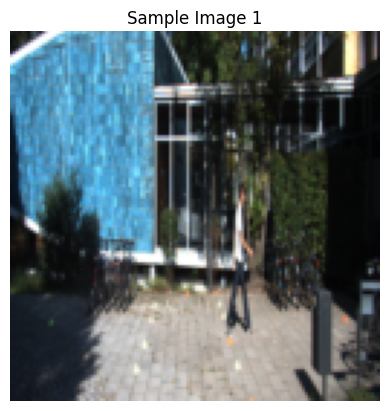

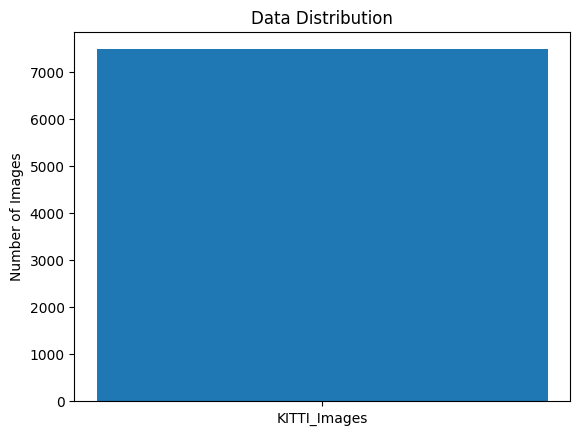

Epoch 1/2:  77%|███████▋  | 359/468 [02:32<00:43,  2.51it/s, loss=0.213]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 1/2: 100%|██████████| 468/468 [03:19<00:00,  2.35it/s, loss=0.192]


Epoch [1/2], Avg Loss: 0.3833
Model checkpoint saved at diffusion_model_epoch_1.pth


Epoch 2/2:   9%|▉         | 42/468 [00:17<02:31,  2.81it/s, loss=0.108]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 2/2: 100%|██████████| 468/468 [03:10<00:00,  2.46it/s, loss=0.0854]


Epoch [2/2], Avg Loss: 0.0985
Model checkpoint saved at diffusion_model_epoch_2.pth


Evaluation done. Samples generated.

Running experiment with lr=0.0001


Epoch 1/5:  71%|███████   | 333/468 [02:17<01:04,  2.08it/s, loss=0.332]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 1/5: 100%|██████████| 468/468 [03:12<00:00,  2.43it/s, loss=0.285]


Epoch [1/5], Avg Loss: 0.4571
Model checkpoint saved at diffusion_model_epoch_1.pth


Epoch 2/5:  34%|███▍      | 159/468 [01:05<01:55,  2.68it/s, loss=0.0984]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 2/5: 100%|██████████| 468/468 [03:09<00:00,  2.47it/s, loss=0.0832]


Epoch [2/5], Avg Loss: 0.1196
Model checkpoint saved at diffusion_model_epoch_2.pth


Epoch 3/5:  77%|███████▋  | 361/468 [02:23<00:49,  2.16it/s, loss=0.0601]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 3/5: 100%|██████████| 468/468 [03:05<00:00,  2.52it/s, loss=0.0609]


Epoch [3/5], Avg Loss: 0.0992
Model checkpoint saved at diffusion_model_epoch_3.pth


  0%|          | 0/468 [00:00<?, ?it/s]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 4/5: 100%|██████████| 468/468 [03:09<00:00,  2.48it/s, loss=0.0486]


Epoch [4/5], Avg Loss: 0.0734
Model checkpoint saved at diffusion_model_epoch_4.pth


Epoch 5/5:  53%|█████▎    | 249/468 [01:38<01:18,  2.78it/s, loss=0.0426]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 5/5: 100%|██████████| 468/468 [03:06<00:00,  2.51it/s, loss=0.0331]


Epoch [5/5], Avg Loss: 0.0666
Model checkpoint saved at diffusion_model_epoch_5.pth



Running experiment with lr=0.0002


Epoch 1/5:  59%|█████▉    | 275/468 [02:00<01:16,  2.51it/s, loss=0.252]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 1/5: 100%|██████████| 468/468 [03:19<00:00,  2.35it/s, loss=0.231]


Epoch [1/5], Avg Loss: 0.3657
Model checkpoint saved at diffusion_model_epoch_1.pth


Epoch 2/5:  68%|██████▊   | 316/468 [02:07<00:55,  2.75it/s, loss=0.0617]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 2/5: 100%|██████████| 468/468 [03:08<00:00,  2.49it/s, loss=0.0589]


Epoch [2/5], Avg Loss: 0.0991
Model checkpoint saved at diffusion_model_epoch_2.pth


Epoch 3/5:  47%|████▋     | 219/468 [01:27<01:39,  2.50it/s, loss=0.0824]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 3/5: 100%|██████████| 468/468 [03:06<00:00,  2.51it/s, loss=0.0655]


Epoch [3/5], Avg Loss: 0.0731
Model checkpoint saved at diffusion_model_epoch_3.pth


Epoch 4/5:  12%|█▏        | 54/468 [00:21<02:39,  2.60it/s, loss=0.094]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 4/5: 100%|██████████| 468/468 [03:07<00:00,  2.50it/s, loss=0.0637]


Epoch [4/5], Avg Loss: 0.0604
Model checkpoint saved at diffusion_model_epoch_4.pth


Epoch 5/5:  85%|████████▍ | 397/468 [02:38<00:30,  2.31it/s, loss=0.0258]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 5/5: 100%|██████████| 468/468 [03:06<00:00,  2.51it/s, loss=0.108]


Epoch [5/5], Avg Loss: 0.0512
Model checkpoint saved at diffusion_model_epoch_5.pth



Running experiment with lr=0.0005


Epoch 1/5:  44%|████▎     | 204/468 [01:21<01:48,  2.43it/s, loss=0.19]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 1/5: 100%|██████████| 468/468 [03:08<00:00,  2.48it/s, loss=0.15]


Epoch [1/5], Avg Loss: 0.3022
Model checkpoint saved at diffusion_model_epoch_1.pth


Epoch 2/5:  31%|███       | 143/468 [00:56<01:58,  2.73it/s, loss=0.0554]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 2/5: 100%|██████████| 468/468 [03:05<00:00,  2.52it/s, loss=0.0439]


Epoch [2/5], Avg Loss: 0.4244


Epoch 3/5:  10%|▉         | 45/468 [00:18<02:42,  2.60it/s, loss=0.0504]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 3/5: 100%|██████████| 468/468 [03:05<00:00,  2.53it/s, loss=0.0861]


Epoch [3/5], Avg Loss: 0.0671
Model checkpoint saved at diffusion_model_epoch_3.pth


Epoch 4/5:  81%|████████  | 379/468 [02:30<00:32,  2.73it/s, loss=0.0408]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 4/5: 100%|██████████| 468/468 [03:05<00:00,  2.53it/s, loss=0.0273]


Epoch [4/5], Avg Loss: 0.0563
Model checkpoint saved at diffusion_model_epoch_4.pth


Epoch 5/5:  93%|█████████▎| 437/468 [02:53<00:11,  2.76it/s, loss=0.0323]

Error loading image /content/drive/My Drive/KITTI_Dataset/data_object_image_2/training/image_2/004307.png: image file is truncated


Epoch 5/5: 100%|██████████| 468/468 [03:06<00:00,  2.51it/s, loss=0.0525]


Epoch [5/5], Avg Loss: 0.0492
Model checkpoint saved at diffusion_model_epoch_5.pth


Training and evaluation completed. Check generated sample images and plots for analysis.
Discuss the convergence, the number of epochs needed, overfitting/underfitting based on the generated results and loss curves.


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

###############################
# Dataset Definition
###############################
class KittiDataset(Dataset):
    def __init__(self, root_dir, split='train', image_set='image_2', transform=None, max_samples=None):
        self.root_dir = root_dir
        self.split = split
        self.image_set = image_set
        self.transform = transform

        self.image_dir = os.path.join(
            self.root_dir,
            'data_object_image_2' if image_set == 'image_2' else 'data_object_image_3',
            'training' if split == 'train' else 'testing',
            image_set
        )

        self.image_files = sorted(os.listdir(self.image_dir))
        if max_samples:
            self.image_files = self.image_files[:max_samples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return torch.zeros(3, 128, 128)

        if self.transform:
            image = self.transform(image)
        return image

###############################
# U-Net Model with optional Dropout
###############################
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512, 1024], use_dropout=False):
        super(UNet, self).__init__()
        self.use_dropout = use_dropout
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Positional embedding for timestep
        self.time_embedding = nn.Sequential(
            nn.Linear(1, features[0]),
            nn.ReLU(),
            nn.Linear(features[0], features[0])
        )

        # Project timestep embedding to match the input channels
        self.time_projection = nn.Conv2d(features[0], in_channels, kernel_size=1)

        in_c = in_channels
        for feature in features:
            self.encoder.append(self._block(in_c, feature))
            in_c = feature

        self.bottleneck = self._block(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(self._block(feature * 2, feature))

        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x, t):
        t = t.view(-1, 1).float()
        t_embedding = self.time_embedding(t)
        t_embedding = t_embedding.view(t_embedding.shape[0], t_embedding.shape[1], 1, 1)
        t_embedding = self.time_projection(t_embedding)

        x = x + t_embedding

        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.pad(x, (0, skip_connection.shape[3] - x.shape[3],
                              0, skip_connection.shape[2] - x.shape[2]))

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)

        return self.final_layer(x)

    def _block(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if self.use_dropout:
            layers.append(nn.Dropout(0.3))
        return nn.Sequential(*layers)

###############################
# Diffusion Process Functions
###############################
def linear_beta_schedule(timesteps):
    return torch.linspace(1e-4, 0.02, timesteps)

def forward_diffusion_sample(x_0, t, alphas_cumprod, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    batch_size = x_0.shape[0]
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod.gather(0, t)).view(batch_size, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = torch.sqrt((1 - alphas_cumprod).gather(0, t)).view(batch_size, 1, 1, 1)
    x_t = sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise
    return x_t, noise

def sample(model, timesteps, shape, betas, alphas, alphas_cumprod, device):
    model.eval()
    with torch.no_grad():
        x = torch.randn(shape).to(device)
        for t in range(timesteps - 1, -1, -1):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            predicted_noise = model(x, t_tensor)
            alpha = alphas[t]
            alpha_cumprod_t = alphas_cumprod[t]
            beta = betas[t]
            noise = torch.randn_like(x) if t > 0 else 0
            x = (1 / torch.sqrt(alpha)) * (
                x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise
            ) + torch.sqrt(beta) * noise
    return x

###############################
# Visualization Functions
###############################
def show_sample_images_from_dataset(dataset, n=1):
    for i in range(n):
        img = dataset[i]
        img_vis = img * 0.5 + 0.5
        np_img = img_vis.permute(1,2,0).numpy()
        plt.imshow(np_img)
        plt.title(f"Sample Image {i+1}")
        plt.axis('off')
        plt.show()

def show_data_distribution(dataset):
    # Simple count of total images
    counts = len(dataset)
    plt.bar(['KITTI_Images'], [counts])
    plt.title("Data Distribution")
    plt.ylabel("Number of Images")
    plt.show()

def save_sample_images(samples, epoch):
    samples = (samples + 1) / 2
    grid = utils.make_grid(samples, nrow=4)
    np_grid = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.title(f"Generated Samples at Epoch {epoch}")
    plt.savefig(f"sample_epoch_{epoch}.png")
    plt.close()

def plot_training_loss(loss_history):
    plt.figure(figsize=(10,5))
    plt.plot(loss_history, label='Training Loss')
    plt.title("Training Loss Over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("training_loss_curve.png")
    plt.close()

###############################
# Placeholder for FID (Implement as needed)
###############################
def compute_fid(real_images, generated_images):
    # Placeholder - implement actual FID calculation or use a library
    return 0.0

###############################
# Training and Evaluation
###############################
def train_model(model, train_loader, optimizer, loss_fn, epochs, device, timesteps, alphas_cumprod, betas, alphas,
                image_size, early_stopping_patience=5):
    model.train()
    best_loss = float('inf')
    no_improve_count = 0
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        loop = tqdm(train_loader, leave=True)
        for images in loop:
            images = images.to(device)
            t = torch.randint(0, timesteps, (images.size(0),), device=device).long()
            x_t, noise = forward_diffusion_sample(images, t, alphas_cumprod)
            predicted_noise = model(x_t, t)
            loss = loss_fn(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            loss_history.append(loss.item())
            loop.set_description(f"Epoch {epoch + 1}/{epochs}")
            loop.set_postfix(loss=loss.item())

        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}")

        # Early Stopping and Checkpoint
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            no_improve_count = 0
            checkpoint_path = f"diffusion_model_epoch_{epoch + 1}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model checkpoint saved at {checkpoint_path}")
        else:
            no_improve_count += 1
            if no_improve_count >= early_stopping_patience:
                print("Early stopping triggered.")
                break

        # Generate samples each epoch
        with torch.no_grad():
            samples = sample(model, timesteps, shape=(8, 3, image_size, image_size), betas=betas, alphas=alphas,
                             alphas_cumprod=alphas_cumprod, device=device)
            save_sample_images(samples, epoch + 1)

    return loss_history

def evaluate_model(model, device, timesteps, betas, alphas, alphas_cumprod, image_size):
    model.eval()
    with torch.no_grad():
        samples = sample(model, timesteps, shape=(8, 3, image_size, image_size), betas=betas, alphas=alphas,
                         alphas_cumprod=alphas_cumprod, device=device)
    # Placeholder for FID or other metrics
    # fid = compute_fid(real_images, samples)
    # print("FID:", fid)
    print("Evaluation done. Samples generated.")

###############################
# Hyperparameter Experiments
###############################
def run_experiments(train_loader, device, timesteps, alphas_cumprod, betas, alphas, image_size, use_dropout=False, weight_decay=0.0):
    lr_values = [1e-4, 2e-4, 5e-4]
    results = {}
    epochs = 5  # fewer epochs for quick experiments
    for lr in lr_values:
        print(f"\nRunning experiment with lr={lr}")
        model = UNet(in_channels=3, out_channels=3, use_dropout=use_dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_fn = nn.MSELoss()
        loss_history = train_model(model, train_loader, optimizer, loss_fn, epochs=epochs, device=device,
                                   timesteps=timesteps, alphas_cumprod=alphas_cumprod, betas=betas, alphas=alphas,
                                   image_size=image_size, early_stopping_patience=2)
        results[lr] = loss_history

    # Compare results
    plt.figure(figsize=(10,5))
    for lr, hist in results.items():
        plt.plot(hist, label=f"LR={lr}")
    plt.title("Loss Comparison for Different Learning Rates")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("lr_comparison.png")
    plt.close()

    return results

###############################
# Main
###############################
if __name__ == "__main__":
    # Hyperparameters
    dataset_dir =  '/content/drive/My Drive/KITTI_Dataset'  # <-- Change this to your dataset path
    batch_size = 16
    image_size = 128
    epochs = 2
    timesteps = 1000
    lr = 2e-4
    weight_decay = 1e-5   # L2 regularization
    use_dropout = True     # Enable dropout in model

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data Transform
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Dataset and Loader
    train_dataset = KittiDataset(root_dir=dataset_dir, split='train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # Data Visualization
    show_sample_images_from_dataset(train_dataset, n=1)
    show_data_distribution(train_dataset)

    # Beta Schedule
    betas = linear_beta_schedule(timesteps).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    # alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # Not used directly but can be useful.

    # Model, Optimizer, Loss
    model = UNet(in_channels=3, out_channels=3, use_dropout=use_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    # Train
    loss_history = train_model(model, train_loader, optimizer, loss_fn, epochs=epochs, device=device,
                               timesteps=timesteps, alphas_cumprod=alphas_cumprod, betas=betas, alphas=alphas,
                               image_size=image_size, early_stopping_patience=5)
    plot_training_loss(loss_history)

    # Evaluate
    evaluate_model(model, device, timesteps, betas, alphas, alphas_cumprod, image_size)

    # Run a quick experiment to compare different learning rates
    run_experiments(train_loader, device, timesteps, alphas_cumprod, betas, alphas, image_size, use_dropout=use_dropout, weight_decay=weight_decay)

    print("Training and evaluation completed. Check generated sample images and plots for analysis.")
    print("Discuss the convergence, the number of epochs needed, overfitting/underfitting based on the generated results and loss curves.")
